# General information

____________________

In this Jupyter Notebook we will be working with news articles retrieved from <a href='https://inshorts.com'> Inshorts.com</a> a website that gives us short, 60-word news articles on a wide variety of topics. Inshorts provides news for 12 thematically different sets of content like: Sports, Politics, Business and Technology.

The main focus is to cover some aspects of NLP like:
- Data retrieval with web scraping
- Text wrangling and pre-processing
- Parts of Speech tagging + visualizing dependencies
- Named Entity Recognition
- Feature Engineering
- Building classifiers able to recognize type of content based on words used in the article

Let's start off by importing all necessary packages.

# Importing necessary libraries

_________________________

In [1]:
# Basic modules for dataframe manipulation
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Web scraping
from selenium import webdriver
from bs4 import BeautifulSoup
from time import sleep

# NLP
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from contractions import CONTRACTION_MAP
import re
import unicodedata

# Feature Engineering and training/testing dataset creation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing import text, sequence

# Machine Learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from keras import layers, models, optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# Prediction assessment
from helper import print_score, create_confmat, report, plot_auc

# Checking if GPU is available
tf.test.gpu_device_name()
tf.test.is_gpu_available(cuda_only=False)

Using TensorFlow backend.


# Retrieving data
_____________________

In this section we will focus on creating a function for gathering news data from <a href='https://inshorts.com'>Inshorts.com</a>. Since articles are divided by topic and each category displays only ~ 25 articles, we need a solution which will trigger the 'Load more' button desired number of times before retrieving the data and creating a DataFrame, we will achieve this by utilizing Selenium - a popular testing framework - and ChromeDriver. For those who prefer Firefox over Chrome, there is a possibility to use Mozilla's GeckoDriver with Selenium.

In [2]:
source_urls = ['https://inshorts.com/en/read/business',
               'https://inshorts.com/en/read/technology',
               'https://inshorts.com/en/read/science',
               'https://inshorts.com/en/read/world',
               'https://inshorts.com/en/read/sports',
               'https://inshorts.com/en/read/politics',
               'https://inshorts.com/en/read/entertainment',
               'https://inshorts.com/en/read/hatke',
               'https://inshorts.com/en/read/automobile']

PATH = 'chromedriver.exe'

In [3]:
def get_data(seed_urls):
    news_data = []
    for url in seed_urls:
        # Creating a new Chrome session
        driver = webdriver.Chrome(PATH)
        driver.implicitly_wait(30)
        driver.get(url)
        for i in range(20):
            try:
                python_button = driver.find_element_by_id('load-more-btn') # Find 'Load more' button
                sleep(2)
                python_button.click() # Click 'Load more' button to load more articles
                sleep(5)
            except Exception as e:
                print(e)
                break
        news_category = url.split('/')[-1]
        soup = BeautifulSoup(driver.page_source, 'html.parser')     
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        driver.quit()
    df =  pd.DataFrame(news_data)
    return df

In [ ]:
df_news = get_data(source_urls)

In [ ]:
# Printing first 5 rows of data
df_news.head()

In [ ]:
# Checking the distribution of each topic in our DataFrame
df_news['news_category'].value_counts()

In [ ]:
# Saving data into a '.csv' file to prevent redundant overloading of the Inshort's server.
df_news.to_csv('data/news.csv', index=False, encoding='utf-8')

In [4]:
df_news = pd.read_csv('data/news.csv')

# Text pre-processing

_________________________

In [5]:
# Loading one of English language models for spacy
nlp = spacy.load('en_core_web_md', parse = True, tag = True, entity = True)
tokenizer = ToktokTokenizer()

# Saving english stopwords from nltk module in a list
stopword_list = nltk.corpus.stopwords.words('english')

## Writing helper functions
___________________


### Removing HTML tags


Let's start off our data preparation by writing some helper functions which we will use to clean the news data. Since HTML tags don't add much value towards understanding and analyzing text, we will get rid of them.

In [6]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

### Removing accented characters

While dealing with text data, very often we encounter accented characters like 'é' or 'ó'. Since they may not be useful while working with English language, we will create function for converting them into unaccented counterparts.

In [7]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

### Expanding contractions

As a next step, let's create a function for dealing with contractions. Contractions are shortened versions of words or syllabes which often exist in written or spoken forms in English language. The typical examples would be <b>do not</b> to <b>don't</b> and <b>I would</b> to <b>I'd</b>. For this purpose we will utilize function and contractions dictionary written by Dipanjan S - Data Scientist working for Intel company, author of <i>Text analytics with Python</i> and <i>Practical machine learning with Python</i>.

<a href="https://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/bonus%20content/nlp%20proven%20approach">Contraction dictionary by Dipanjan S</a>

In [8]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

### Removing special characters

Special characters are usually non-alphanumeric or even numeric characters which constitute to the extra noise in unstructured text data. We will create a function based on simple regular expressions which will get rid of them.

In [9]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

### Lemmatization

In computational linguistics, lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning. It depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document. For this part we will utilize <b>Spacy</b> as it has excellent built-in lemmatizers.

In [10]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

### Removing Stopwords

In computing, <i>stopwords</i> are words which are filtered out before or after processing of natural language data. Though stopwords usually refer to the most common words in a language, there is no single universal list of stop words used by all natural language processing tools, and indeed not all tools even use such a list. Some tools specifically avoid removing these stop words to support phrase search. Some examples include <b>a</b>, <b>an</b>, <b>the</b>, <b>and</b>.

In [11]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

### Combining above functions - building a Text Normalizer

In [12]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=False):
    
    normalized_corpus = []
    # Normalizing each document in the corpus
    for doc in corpus:
        # Stripping HTML
        if html_stripping:
            doc = remove_html_tags(doc)
        # Removing accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # Expanding contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # Lowering the text    
        if text_lower_case:
            doc = doc.lower()
        # Removing extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # Lemmatizing text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # Removing special characters and\or digits    
        if special_char_removal:
            # Inserting spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # Removing extra whitespace
        doc = re.sub(' +', ' ', doc)
        # Removing stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [13]:
# Combining headline and article text
df_news['full_text'] = df_news["news_headline"].map(str)+ '. ' + df_news["news_article"]

# Pre-processing text and store the same
df_news['clean_text'] = normalize_corpus(df_news['full_text'])
norm_corpus = list(df_news['clean_text'])

# Displaying first 5 rows
df_news.head()

,news_article,news_category,news_headline,full_text,clean_text
0,"When deciding the right term insurance plan, c...",business,Max Life Insurance delivering high claims paid...,Max Life Insurance delivering high claims paid...,max life insurance deliver high claim pay 4 ye...
1,Andhra Pradesh has topped the ease of doing bu...,business,Andhra Pradesh tops ease of doing business ran...,Andhra Pradesh tops ease of doing business ran...,andhra pradesh top ease business rank 2nd year...
2,Rajinikanth's wife Latha Rajinikanth will have...,business,Rajinikanth's wife to face trial for fraud ove...,Rajinikanth's wife to face trial for fraud ove...,rajinikanth wife face trial fraud 6 cr unpaid ...
3,Online payments company PayPal's UK unit sent ...,business,"Being dead is breach of contract, PayPal tells...","Being dead is breach of contract, PayPal tells...",dead breach contract paypal tell deceased pati...
4,"The world's fifth largest smartphone seller, C...",business,World's 5th largest smartphone seller Xiaomi m...,World's 5th largest smartphone seller Xiaomi m...,world 5th large smartphone seller xiaomi make ...


In [14]:
# Saving preprocessed DataFrame into .csv file
df_news.to_csv('data/news_preprocessed.csv', index=False, encoding='utf-8')

# Parts of Speech tagging

______________________________

Parts of speech (POS) are specific lexical categories to which words are assigned, based on their syntactic context and role. Usually, words can fall into one of the following major categories.

- <b>Noun</b>: This usually denotes words that depict some object or entity, which may be living or nonliving. Some examples would be fox , dog , book , and so on. The POS tag symbol for nouns is N.

- <b>Verb</b>: Verbs are words that are used to describe certain actions, states, or occurrences. There are a wide variety of further subcategories, such as auxiliary, reflexive, and transitive verbs (and many more). Some typical examples of verbs would be running , jumping , read , and write . The POS tag symbol for verbs is V.

- <b>Adjective</b>: Adjectives are words used to describe or qualify other words, typically nouns and noun phrases. The phrase beautiful flower has the noun (N) flower which is described or qualified using the adjective (ADJ) beautiful . The POS tag symbol for adjectives is ADJ .

- <b>Adverb</b>: Adverbs usually act as modifiers for other words including nouns, adjectives, verbs, or other adverbs. The phrase very beautiful flower has the adverb (ADV) very , which modifies the adjective (ADJ) beautiful , indicating the degree to which the flower is beautiful. The POS tag symbol for adverbs is ADV.

Besides these four major categories of parts of speech , there are other categories that occur frequently in the English language. These include pronouns, prepositions, interjections, conjunctions, determiners, and many others. Furthermore, each POS tag like the noun (N) can be further subdivided into categories like singular nouns (NN), singular proper nouns (NNP), and plural nouns (NNS).



Since in this Jupyter Notebook we are going to show examples of Parts of Speech tagging and Named Entity Recognition using Spacy with 'en_core_web_md' model, we will apply them on the unprocessed data as it was proved and described in the below article that lowering the case or lemmatizing ruins the precision of these models. 


<a href='https://medium.com/@dudsdu/named-entity-recognition-for-unstructured-documents-c325d47c7e3a'>Named Entity Recognition for Unstructured Documents</a>

In [15]:
# Displaying first 5 rows
df_news.head()

,news_article,news_category,news_headline,full_text,clean_text
0,"When deciding the right term insurance plan, c...",business,Max Life Insurance delivering high claims paid...,Max Life Insurance delivering high claims paid...,max life insurance deliver high claim pay 4 ye...
1,Andhra Pradesh has topped the ease of doing bu...,business,Andhra Pradesh tops ease of doing business ran...,Andhra Pradesh tops ease of doing business ran...,andhra pradesh top ease business rank 2nd year...
2,Rajinikanth's wife Latha Rajinikanth will have...,business,Rajinikanth's wife to face trial for fraud ove...,Rajinikanth's wife to face trial for fraud ove...,rajinikanth wife face trial fraud 6 cr unpaid ...
3,Online payments company PayPal's UK unit sent ...,business,"Being dead is breach of contract, PayPal tells...","Being dead is breach of contract, PayPal tells...",dead breach contract paypal tell deceased pati...
4,"The world's fifth largest smartphone seller, C...",business,World's 5th largest smartphone seller Xiaomi m...,World's 5th largest smartphone seller Xiaomi m...,world 5th large smartphone seller xiaomi make ...


In [16]:
# Randomly selecting exemplary news_headline for POS tagging
doc = str(df_news.loc[np.random.choice(np.arange(len(df_news)), 1).item(), 'news_headline'])
doc = nlp(doc)

# POS tagging
pos_tagged = [(word, word.pos_, spacy.explain(word.pos_), word.tag_, spacy.explain(word.tag_)) for word in doc]
df_doc = pd.DataFrame(pos_tagged, columns=['word', 'simple_POS_tag', 'simple_POS_tag_description', 'detailed_POS_tag', 'detailed_POS_tag_description'])
df_doc

,word,simple_POS_tag,simple_POS_tag_description,detailed_POS_tag,detailed_POS_tag_description
0,Our,ADJ,adjective,PRP$,"pronoun, possessive"
1,govt,NOUN,noun,NN,"noun, singular or mass"
2,'s,PART,particle,POS,possessive ending
3,performance,NOUN,noun,NN,"noun, singular or mass"
4,far,ADV,adverb,RB,adverb
5,better,ADJ,adjective,JJR,"adjective, comparative"
6,than,ADP,adposition,IN,"conjunction, subordinating or preposition"
7,Samajwadi,PROPN,proper noun,NNP,"noun, proper singular"
8,Party,PROPN,proper noun,NNP,"noun, proper singular"
9,:,PUNCT,punctuation,:,"punctuation mark, colon or ellipsis"


In [17]:
# Importing dependency visualizer that lets us check model's predictions in Jupyter notebook or browser
from spacy import displacy

displacy.render(doc, style='dep', jupyter = True)

# Named Entity Recognition

_______________________________

Named Entity Recognition (NER) is a process where an algorithm takes a string of text (sentence or paragraph) as input and identifies relevant nouns that are mentioned in that string which more specifically refer to terms that represent real-world objects like people, places, organizations. Named entity recognition, also known as entity chunking/extraction, is a popular technique used in information extraction to identify and segment the named entities and classify or categorize them under various predefined classes. Now, let's check how to find them using Spacy.

In [19]:
# Randomly selecting exemplary news article for NER 
doc2 = str(df_news.loc[np.random.choice(np.arange(len(df_news)), 1).item(), 'news_article'])
doc2 = nlp(doc2)

# Finding Named Entities in the article
ne_list = [(word, word.ent_type_) for word in doc2 if word.ent_type_]

# Visualizing Named Entities
displacy.render(doc2, style='ent', jupyter=True)

<b>Example screenshot of NER visualization as Github is not displaying them properly</b>

<img src='images/NER_image.png'>

Now, let's find out what these entity types exactly mean...

In [20]:
# Selecting unique types of Named Enities found by Spacy
unique_ne_type = set(tup[1] for tup in ne_list)
unique_list = [(ne, spacy.explain(ne)) for ne in unique_ne_type]

# Dispalying unique types of Named Entities along with their descriptions
df_doc2 = pd.DataFrame(unique_list, columns=['entity_type', 'entity_description'])
df_doc2

,entity_type,entity_description
0,PRODUCT,"Objects, vehicles, foods, etc. (not services)"
1,GPE,"Countries, cities, states"
2,PERSON,"People, including fictional"
3,ORG,"Companies, agencies, institutions, etc."


Before delving into the Machine Learning part, let's scan our news corpus and reveal what are the most frequent entities using the following code. 

In [21]:
# Creating basic pre-processed corpus
news_corpus = normalize_corpus(df_news['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

In [22]:
entities_list = []
for sentence in news_corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                entities_list.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

df_entity = pd.DataFrame(entities_list, columns=['entity_name', 'entity_type'])

In [23]:
df_entity.groupby(by = ['entity_name', 'entity_type']).size().sort_values(ascending = False).reset_index().rename(columns={0: 'Count'})[:15]

,entity_name,entity_type,Count
0,US,GPE,1037
1,first,ORDINAL,446
2,India,GPE,436
3,Congress,ORG,347
4,Indian,NORP,299
5,two,CARDINAL,295
6,Tesla,ORG,190
7,one,CARDINAL,188
8,China,GPE,186
9,UK,GPE,182


# Feature Engineering

_____________________________

In this section we are going to split our dataset into the training and testing subsets and take care of feature engineering. Here, the pre-processed text data will be transformed into feature vectors. We will implement the following different ideas in order to obtain relevant features from our dataset:
<br><br>
- TF-IDF Vectors as features<br><br>
&emsp;&bull;&emsp;Word level<br>
&emsp;&bull;&emsp;N-gram level <br><br>
- Word Embeddings as features


In [24]:
X = df_news['clean_text']
y = df_news['news_category'].astype('category').cat.codes

# Splitting data into training and validation subsets for traditional ML algorithms
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle = True, random_state = 42, test_size = 0.3)


# Creating zero/ones matrix indicating article category label for Neural Networks
labels_flat = y.values.ravel()
labels_count = np.unique(labels_flat).shape[0]

# Function for creating zero/ones matrix indicating article category label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
    return labels_one_hot


labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

# Splitting the data into training and validation subsets for Neural Networks. Setting same seed will ensure
# the same sampling

X_train, X_val, y_train_net, y_val_net = train_test_split(X, labels, shuffle = True, random_state = 42, test_size = 0.3)

## TF-IDF Vectors

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: first one computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.<br><br>

<b>TF(t)</b> =  <span style= "color:red;">(Number of times term t appears in a document)</span> / <span style= "color:red;">(Total number of terms in the document)</span>

<b>IDF(t)</b> =  log_e<span style= "color:red;">(Total number of documents</span> / <span style= "color:red;">Number of documents with term t in it)</span><br><br>

TF-IDF vectors can be generated at different levels of input tokens: words, n-grams and characters, but in this notebook we will limit our research only to word and n-gram levels.

In [25]:
max_features = 10000

# Creating word-level TF-IDF vectors
tfidf_word_vect = TfidfVectorizer(max_features = max_features, analyzer='word')
tfidf_word_vect.fit(X_train)
X_train_word_tfidf = tfidf_word_vect.transform(X_train)
X_val_word_tfidf = tfidf_word_vect.transform(X_val)


# Creating ngram-level TF-IDF vectors
tfidf_ngram_vect = TfidfVectorizer(max_features = max_features, analyzer='word', ngram_range = (2,3))
tfidf_ngram_vect.fit(X_train)
X_train_ngram_tfidf = tfidf_ngram_vect.transform(X_train)
X_val_ngram_tfidf = tfidf_ngram_vect.transform(X_val)

## Word Embeddings

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation.The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. Word embeddings can be trained using the input corpus itself or can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec. Any one of them can be downloaded and used as so-called transfer learning. 

In this task we will utilize pre-trained embeddings from FastText containing 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens). They can be downloaded from the below website:

<a href="https://fasttext.cc/docs/en/english-vectors.html">FastText pre-trained word embeddings</a>

In [26]:
# Loading pre-trained word-embedding vectors

embedding_dict = {}

for _, line in enumerate(open('../wiki-news-300d-1M.vec')):
    values = line.split()
    embedding_dict[values[0]] = np.asarray(values[1:], dtype='float32')

In [27]:
# Instantiating tokenizer from keras.preprocessing module
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(X_train)
word_indexes = tokenizer.word_index

In [28]:
max_article_length = 60
pad_type = trunc_type = 'pre'

# Converting text into sequences of tokens, adding padding to ensure equality of vector lenghts
X_train_seq =  sequence.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_article_length, padding = pad_type, truncating = trunc_type)
X_val_seq = sequence.pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = max_article_length, padding = pad_type, truncating = trunc_type)

# Building classifiers

_______________________________

The final step in the text classification framework is to train a classifier using the features created in the previous step. There are many different choices of Machine Learning models which can be used to train a final model. We will implement following different classifiers for this purpose:

- Naive Bayes Classifier
- Linear Classifier
- Support Vector Machine
- Convolutional Neural Network (CNN)
- Long Short Term Memory Network (LSTM)
- Bidirectional LSTM Network (Bi-LSTM)

## Naive Bayes Classifier

Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature

Training accuracy: 0.9270508089696281, Test accuracy: 0.8391793514228988


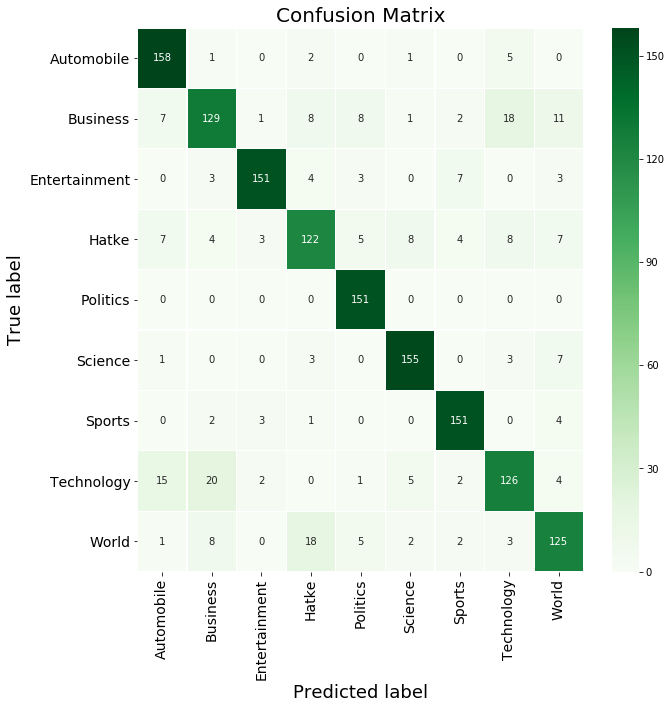

True negatives: 158  |  False negatives: 7  |  True positives: 129  |  False positives: 1
Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.95      0.89       167
          1       0.77      0.70      0.73       185
          2       0.94      0.88      0.91       171
          3       0.77      0.73      0.75       168
          4       0.87      1.00      0.93       151
          5       0.90      0.92      0.91       169
          6       0.90      0.94      0.92       161
          7       0.77      0.72      0.75       175
          8       0.78      0.76      0.77       164

avg / total       0.84      0.84      0.84      1511



In [29]:
# Naive Bayes using word-level TF-IDF vectors
naive_clf_word = MultinomialNB()
naive_clf_word.fit(X_train_word_tfidf, y_train)

print_score(naive_clf_word, X_train_word_tfidf, X_val_word_tfidf, y_train, y_val, auc = False)
create_confmat(naive_clf_word, X_val_word_tfidf, y_val, ['Automobile', 'Business', 'Entertainment',
                                          'Hatke', 'Politics', 'Science', 'Sports',
                                          'Technology', 'World'], size = (10,10), colour = 'Greens')
report(naive_clf_word, X_val_word_tfidf, y_val)

Training accuracy: 0.9253477150156117, Test accuracy: 0.7412309728656519


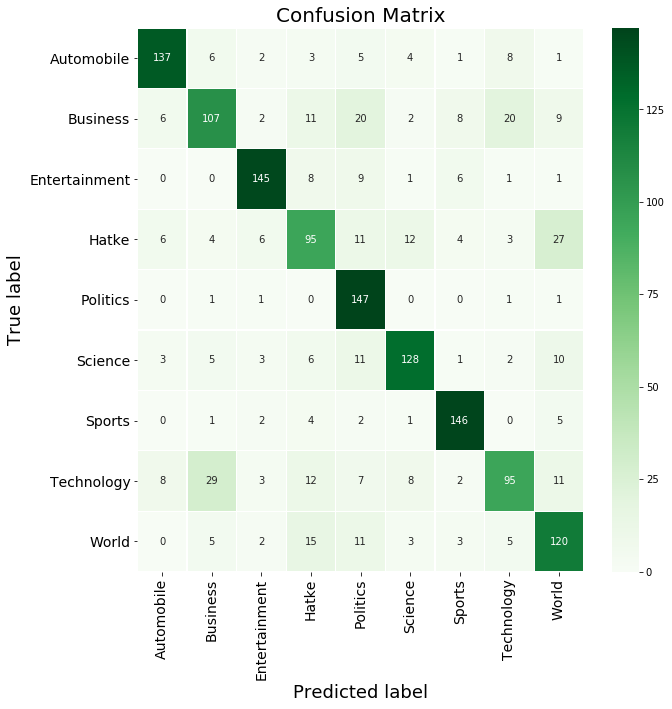

True negatives: 137  |  False negatives: 6  |  True positives: 107  |  False positives: 6
Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.82      0.84       167
          1       0.68      0.58      0.62       185
          2       0.87      0.85      0.86       171
          3       0.62      0.57      0.59       168
          4       0.66      0.97      0.79       151
          5       0.81      0.76      0.78       169
          6       0.85      0.91      0.88       161
          7       0.70      0.54      0.61       175
          8       0.65      0.73      0.69       164

avg / total       0.74      0.74      0.74      1511



In [30]:
# Naive Bayes using ngram-level TF-IDF vectors
naive_clf_ngram = MultinomialNB()
naive_clf_ngram.fit(X_train_ngram_tfidf, y_train)

print_score(naive_clf_ngram, X_train_ngram_tfidf, X_val_ngram_tfidf, y_train, y_val, auc = False)
create_confmat(naive_clf_ngram, X_val_ngram_tfidf, y_val, ['Automobile', 'Business', 'Entertainment',
                                          'Hatke', 'Politics', 'Science', 'Sports',
                                          'Technology', 'World'], size = (10,10), colour = 'Greens')
report(naive_clf_ngram, X_val_ngram_tfidf, y_val)

## Linear Classifier (Logistic Regression)

Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function.

Training accuracy: 0.9324439398240136, Test accuracy: 0.8398411647915288


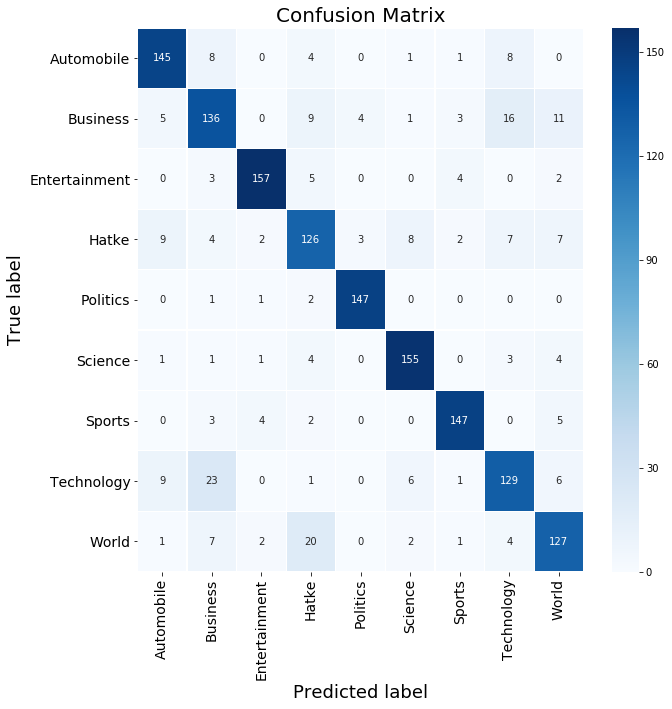

True negatives: 145  |  False negatives: 5  |  True positives: 136  |  False positives: 8
Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.87      0.86       167
          1       0.73      0.74      0.73       185
          2       0.94      0.92      0.93       171
          3       0.73      0.75      0.74       168
          4       0.95      0.97      0.96       151
          5       0.90      0.92      0.91       169
          6       0.92      0.91      0.92       161
          7       0.77      0.74      0.75       175
          8       0.78      0.77      0.78       164

avg / total       0.84      0.84      0.84      1511



In [31]:
# Linear Classifier trained on word-level TF-IDF vectors
linear_clf_word = LogisticRegression()
linear_clf_word.fit(X_train_word_tfidf, y_train)

print_score(linear_clf_word, X_train_word_tfidf, X_val_word_tfidf, y_train, y_val, auc = False)
create_confmat(linear_clf_word, X_val_word_tfidf, y_val, ['Automobile', 'Business', 'Entertainment',
                                          'Hatke', 'Politics', 'Science', 'Sports',
                                          'Technology', 'World'], size = (10,10), colour = 'Blues')
report(linear_clf_word, X_val_word_tfidf, y_val)

Training accuracy: 0.930173147885325, Test accuracy: 0.7379219060225016


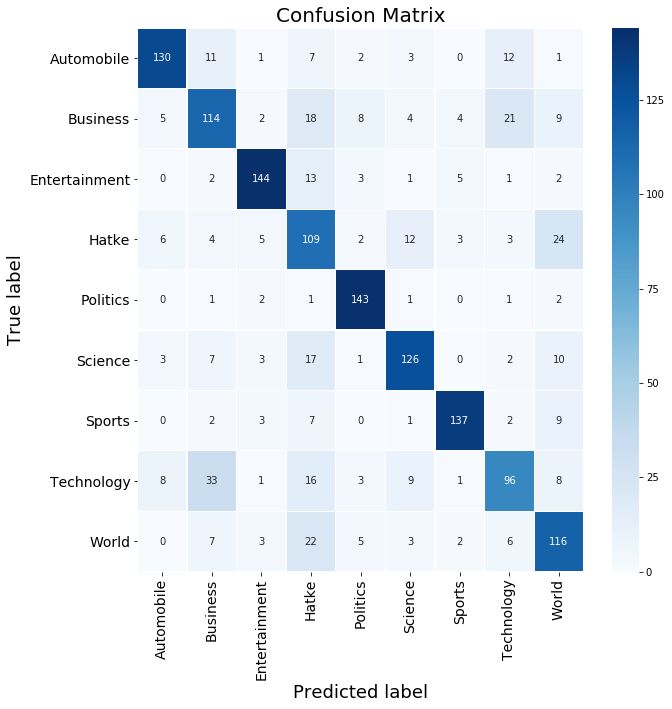

True negatives: 130  |  False negatives: 5  |  True positives: 114  |  False positives: 11
Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.78      0.82       167
          1       0.63      0.62      0.62       185
          2       0.88      0.84      0.86       171
          3       0.52      0.65      0.58       168
          4       0.86      0.95      0.90       151
          5       0.79      0.75      0.77       169
          6       0.90      0.85      0.88       161
          7       0.67      0.55      0.60       175
          8       0.64      0.71      0.67       164

avg / total       0.75      0.74      0.74      1511



In [32]:
# Linear Classifier trained on ngram-level TF-IDF vectors
linear_clf_ngram = LogisticRegression()
linear_clf_ngram.fit(X_train_ngram_tfidf, y_train)

print_score(linear_clf_ngram, X_train_ngram_tfidf, X_val_ngram_tfidf, y_train, y_val, auc = False)
create_confmat(linear_clf_ngram, X_val_ngram_tfidf, y_val, ['Automobile', 'Business', 'Entertainment',
                                          'Hatke', 'Politics', 'Science', 'Sports',
                                          'Technology', 'World'], size = (10,10), colour = 'Blues')
report(linear_clf_ngram, X_val_ngram_tfidf, y_val)

## Support Vector Machine Classifier

“Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. However,  it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the classes very well. To use SVM for multi-class classification problem we need to use <b>one-vs-rest</b> approach. This strategy involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives.

Training accuracy: 0.9676412148736871, Test accuracy: 0.8332230311052283


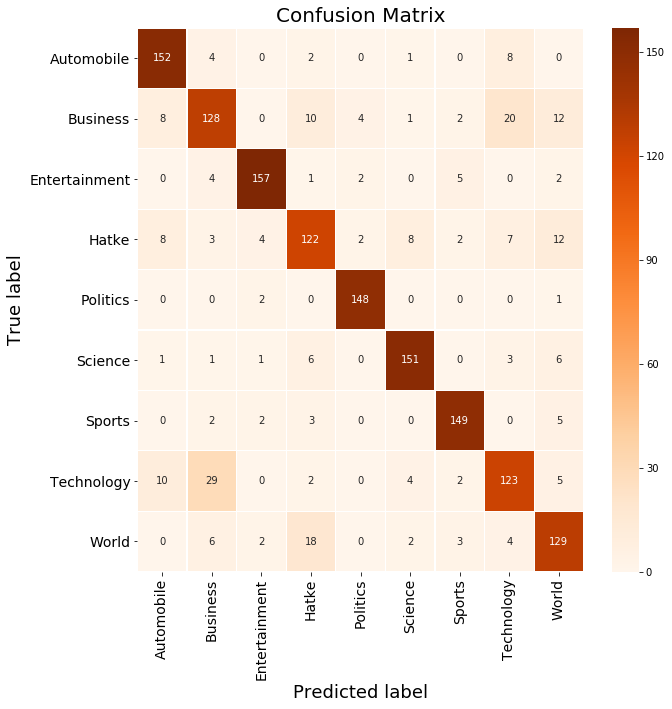

True negatives: 152  |  False negatives: 8  |  True positives: 128  |  False positives: 4
Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.91      0.88       167
          1       0.72      0.69      0.71       185
          2       0.93      0.92      0.93       171
          3       0.74      0.73      0.73       168
          4       0.95      0.98      0.96       151
          5       0.90      0.89      0.90       169
          6       0.91      0.93      0.92       161
          7       0.75      0.70      0.72       175
          8       0.75      0.79      0.77       164

avg / total       0.83      0.83      0.83      1511



In [33]:
# Linear SVM Classifier using “one-vs-rest” multi-class strategy trained on word-level TF-IDF vectors
svc_clf_word = LinearSVC()
svc_clf_word.fit(X_train_word_tfidf, y_train)

print_score(svc_clf_word, X_train_word_tfidf, X_val_word_tfidf, y_train, y_val, auc = False)
create_confmat(svc_clf_word, X_val_word_tfidf, y_val, ['Automobile', 'Business', 'Entertainment',
                                          'Hatke', 'Politics', 'Science', 'Sports',
                                          'Technology', 'World'], size = (10,10), colour = 'Oranges')
report(svc_clf_word, X_val_word_tfidf, y_val)

Training accuracy: 0.9665058189043428, Test accuracy: 0.7260092653871608


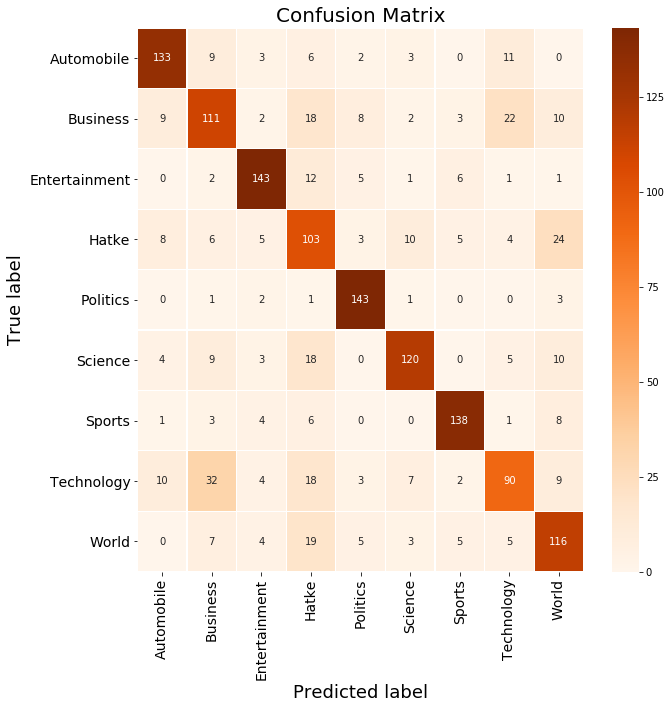

True negatives: 133  |  False negatives: 9  |  True positives: 111  |  False positives: 9
Classification Report:
             precision    recall  f1-score   support

          0       0.81      0.80      0.80       167
          1       0.62      0.60      0.61       185
          2       0.84      0.84      0.84       171
          3       0.51      0.61      0.56       168
          4       0.85      0.95      0.89       151
          5       0.82      0.71      0.76       169
          6       0.87      0.86      0.86       161
          7       0.65      0.51      0.57       175
          8       0.64      0.71      0.67       164

avg / total       0.73      0.73      0.73      1511



In [34]:
# Linear SVM Classifier using “one-vs-rest” multi-class strategy trained on ngram-level TF-IDF vectors
svc_clf_ngram = LinearSVC()
svc_clf_ngram.fit(X_train_ngram_tfidf, y_train)

print_score(svc_clf_ngram, X_train_ngram_tfidf, X_val_ngram_tfidf, y_train, y_val, auc = False)
create_confmat(svc_clf_ngram, X_val_ngram_tfidf, y_val, ['Automobile', 'Business', 'Entertainment',
                                          'Hatke', 'Politics', 'Science', 'Sports',
                                          'Technology', 'World'], size = (10,10), colour = 'Oranges')
report(svc_clf_ngram, X_val_ngram_tfidf, y_val)

## Convolutional Neural Network (CNN)

In Convolutional Neural Networks, convolutions over the input layer are used to compute the output. This results in local connections, where each region of the input is connected to a neuron in the output. Each layer applies different filters and combines their results.

### Setting hyperparameters

In [35]:
output_dir = 'model_output/CONV'

epochs = 10
batch_size = 128

n_dim = 128
n_unique_words = 20000
drop_embed = 0.25

n_dense = 256
dropout = 0.5

n_conv = 256
k_conv = 3

### Designing CNN architecture

In [36]:
model = models.Sequential()
model.add(layers.Embedding(n_unique_words, n_dim, input_length = max_article_length))
model.add(layers.SpatialDropout1D(drop_embed))
model.add(layers.Conv1D(n_conv, k_conv, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_dense, activation = 'relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(len(y.unique()), activation = 'softmax'))

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 128)           2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 58, 256)           98560     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

### Configuring model

In [38]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [39]:
# modelcheckpoint = ModelCheckpoint(filepath = output_dir + "weights.{epoch:02d}.hdf5")
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

### Training model

In [40]:
model.fit(X_train_seq, y_train_net, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data=(X_val_seq, y_val_net))

Train on 3523 samples, validate on 1511 samples
Epoch 1/10
3523/3523 [==============================] - 2s 508us/step - loss: 2.2020 - acc: 0.1164 - val_loss: 2.1835 - val_acc: 0.1370
Epoch 2/10
3523/3523 [==============================] - 0s 63us/step - loss: 2.1626 - acc: 0.1882 - val_loss: 2.1019 - val_acc: 0.3223
Epoch 3/10
3523/3523 [==============================] - 0s 63us/step - loss: 1.9385 - acc: 0.3602 - val_loss: 1.6237 - val_acc: 0.5486
Epoch 4/10
3523/3523 [==============================] - 0s 62us/step - loss: 1.4162 - acc: 0.5637 - val_loss: 1.1361 - val_acc: 0.7022
Epoch 5/10
3523/3523 [==============================] - 0s 63us/step - loss: 0.9924 - acc: 0.7022 - val_loss: 0.8537 - val_acc: 0.7565
Epoch 6/10
3523/3523 [==============================] - 0s 63us/step - loss: 0.7348 - acc: 0.7854 - val_loss: 0.6927 - val_acc: 0.7935
Epoch 7/10
3523/3523 [==============================] - 0s 64us/step - loss: 0.5247 - acc: 0.8527 - val_loss: 0.6337 - val_acc: 0.7955
Epoch 

## Long Short Term Memory (LSTM)

Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons to remember what they have learned so far.

The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.

### Setting hyperparameters

In [41]:
output_dir = 'model_output/LSTM'

epochs = 10
batch_size = 128

n_dim = 128
n_unique_words = 10000
drop_embed = 0.4

n_lstm = 128
drop_lstm = 0.9

### Designing LSTM architecture

In [42]:
model2 = models.Sequential()
model2.add(layers.Embedding(n_unique_words, n_dim, input_length = max_article_length))
model2.add(layers.SpatialDropout1D(drop_embed))
model2.add(layers.LSTM(n_lstm, dropout = drop_lstm))
model2.add(layers.Dense(len(y.unique()), activation = 'softmax'))

In [43]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 128)           1280000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1161      
Total params: 1,412,745
Trainable params: 1,412,745
Non-trainable params: 0
_________________________________________________________________


### Configuring model

In [44]:
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [45]:
# modelcheckpoint = ModelCheckpoint(filepath = output_dir + "weights.{epoch:02d}.hdf5")
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

### Training model

In [46]:
model2.fit(X_train_seq, y_train_net, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data=(X_val_seq, y_val_net))

Train on 3523 samples, validate on 1511 samples
Epoch 1/10
3523/3523 [==============================] - 4s 1ms/step - loss: 2.1963 - acc: 0.1169 - val_loss: 2.1917 - val_acc: 0.1509
Epoch 2/10
3523/3523 [==============================] - 2s 691us/step - loss: 2.1751 - acc: 0.1763 - val_loss: 2.1084 - val_acc: 0.3038
Epoch 3/10
3523/3523 [==============================] - 2s 665us/step - loss: 2.0053 - acc: 0.2478 - val_loss: 1.8022 - val_acc: 0.3230
Epoch 4/10
3523/3523 [==============================] - 2s 689us/step - loss: 1.7703 - acc: 0.3480 - val_loss: 1.5750 - val_acc: 0.3812
Epoch 5/10
3523/3523 [==============================] - 2s 703us/step - loss: 1.5587 - acc: 0.4170 - val_loss: 1.3440 - val_acc: 0.5156
Epoch 6/10
3523/3523 [==============================] - 2s 706us/step - loss: 1.3960 - acc: 0.4891 - val_loss: 1.1915 - val_acc: 0.5354
Epoch 7/10
3523/3523 [==============================] - 2s 701us/step - loss: 1.2121 - acc: 0.5527 - val_loss: 1.0937 - val_acc: 0.5817
Ep

## Bi-Directional LSTM

LSTM in its core preserves information from inputs that have already passed through it using the hidden state.
Unidirectional LSTM only preserves information from the past because the only inputs it has seen are from the past.

Bi-Directional LSTM will run inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backwards we preserve information from the future and using the two hidden states combined we are able in any point in time to preserve information from both past and future. Let's check if they will achieve better prediction accuracy in our case.

### Setting hyperparameters

In [47]:
output_dir = 'model_output/biLSTM'

epochs = 10
batch_size = 128

n_dim = 128
n_unique_words = 5000
drop_embed = 0.4

n_lstm = 256
drop_lstm = 0.5

### Designing Bi-Directional LSTM architecture

In [48]:
model3 = models.Sequential()
model3.add(layers.Embedding(n_unique_words, n_dim, input_length = max_article_length))
model3.add(layers.SpatialDropout1D(drop_embed))
model3.add(layers.wrappers.Bidirectional(layers.LSTM(n_lstm, dropout = drop_lstm)))
model3.add(layers.Dense(len(y.unique()), activation = 'softmax'))

In [49]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 128)           640000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 60, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               788480    
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 4617      
Total params: 1,433,097
Trainable params: 1,433,097
Non-trainable params: 0
_________________________________________________________________


### Configuring model

In [50]:
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [51]:
# modelcheckpoint = ModelCheckpoint(filepath = output_dir + "weights.{epoch:02d}.hdf5")
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

### Training model

In [52]:
model3.fit(X_train_seq, y_train_net, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data=(X_val_seq, y_val_net))

Train on 3523 samples, validate on 1511 samples
Epoch 1/10
3523/3523 [==============================] - 7s 2ms/step - loss: 2.1756 - acc: 0.1587 - val_loss: 2.0024 - val_acc: 0.3349
Epoch 2/10
3523/3523 [==============================] - 4s 1ms/step - loss: 1.6605 - acc: 0.3991 - val_loss: 1.2943 - val_acc: 0.5255
Epoch 3/10
3523/3523 [==============================] - 4s 1ms/step - loss: 1.1161 - acc: 0.5969 - val_loss: 0.9361 - val_acc: 0.6658
Epoch 4/10
3523/3523 [==============================] - 4s 1ms/step - loss: 0.7900 - acc: 0.7187 - val_loss: 0.8386 - val_acc: 0.7081
Epoch 5/10
3523/3523 [==============================] - 4s 1ms/step - loss: 0.6765 - acc: 0.7709 - val_loss: 0.8642 - val_acc: 0.7095
Epoch 6/10
3523/3523 [==============================] - 4s 1ms/step - loss: 0.5505 - acc: 0.8155 - val_loss: 0.8507 - val_acc: 0.7373
Epoch 7/10
3523/3523 [==============================] - 4s 1ms/step - loss: 0.4688 - acc: 0.8527 - val_loss: 0.8196 - val_acc: 0.7426
Epoch 8/10
352

# Conclusion

As we have seen above, the more classical Machine Learning algorithms like Naive Bayes, Logistic Regressic and Support Vector Machine Classifiers achieved better results than CNNs, LSTMs and Bi-Directional LSTMs. This confirms the thesis developed by Google Engineers that for text classification problems where the <b>Number of samples / Number of words per sample</b> ratio is lower than 1500 splitting samples into word n-grams and creating vectors gives higher accuracy rates than using Word Embeddings with RNNs and CNNs.

Detailed text classification guide written be Google Engineers can be found on the below website:<br>
<a href="https://developers.google.com/machine-learning/guides/text-classification/">Text Classification guide</a>